Calculating Static Beta & Z-Score...
Simulating Pairs Strategy (Entry Z: 2.0, Exit Z: 0.5)...

 PERFORMANCE REPORT: Static Cointegration Strategy (CAD/AUD)

[Text Output]
   Quarter  Gross SR    Net SR  Ann. Vol ($)   Gross CR    Net CR  Gross CumP&L   Net CumP&L  Trades (CAD)  Trades (AUD)  Av. Trades      Stat
0  2023_Q1  2.692283  1.668282   4555.238499  10.940856  5.746925   3410.950427  2110.950427          65.0          65.0    1.857143  0.872868
1  2023_Q3  1.337969  0.607695   4960.662371   2.809666  0.955726   1837.380114   837.380114          50.0          50.0    1.428571  0.000000
2  2023_Q4 -1.095817 -1.911834   3972.421169  -1.664777 -2.424470  -1189.613819 -2109.613819          46.0          46.0    1.314286 -1.800446
3  2024_Q2 -1.130278 -2.253080   3061.441446  -2.162122 -2.997054   -963.391659 -1943.391659          49.0          49.0    1.380282 -1.829242
4  2024_Q4  0.161386 -0.669999   3777.463825   0.347896 -1.304880    176.886514  -723.113486          45.0        

,Quarter,Gross SR,Net SR,Ann. Vol ($),Gross CR,Net CR,Gross CumP&L,Net CumP&L,Trades (CAD),Trades (AUD),Av. Trades,Stat
0,2023_Q1,2.69,1.67,"$4,555",10.94,5.75,"$3,411","$2,111",65,65,1.9,0.8729
1,2023_Q3,1.34,0.61,"$4,961",2.81,0.96,"$1,837",$837,50,50,1.4,0.0000
2,2023_Q4,-1.10,-1.91,"$3,972",-1.66,-2.42,"$-1,190","$-2,110",46,46,1.3,-1.8004
3,2024_Q2,-1.13,-2.25,"$3,061",-2.16,-3.00,$-963,"$-1,943",49,49,1.4,-1.8292
4,2024_Q4,0.16,-0.67,"$3,777",0.35,-1.30,$177,$-723,45,45,1.2,-0.0000
5,2025_Q1,-2.00,-3.10,"$3,014",-3.08,-3.41,"$-1,615","$-2,555",47,47,1.4,-3.3728
6,2025_Q2,-0.39,-1.28,"$3,751",-0.61,-1.63,$-410,"$-1,350",47,47,1.3,-0.5336
7,TOTAL,-,-,"$3,918",-,-,"$1,247","$-5,733",349,349,1.4,-6.6632



 TOTAL RANKING SCORE: -6.6632


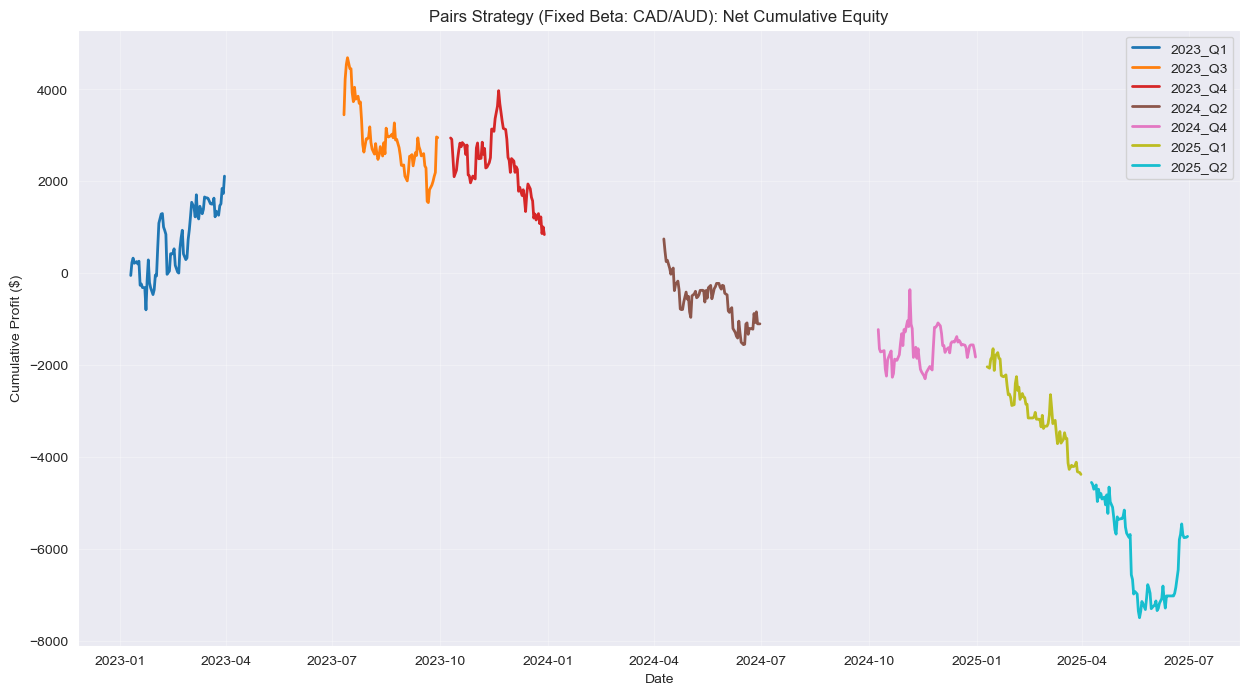

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

# Filter warnings for cleaner output
warnings.filterwarnings('ignore')


# ==========================================
# 1. Configuration
# ==========================================
class Config:
    # File Path
    FILE_PATH = '../../preprocess/df_g2_processed.pkl'
    ASSETS = ['CAD', 'AUD']  # CAD=Y, AUD=X

    # Contract Specifications
    # FX標準(10万通貨)の仕様に設定
    SPECS = {
        'CAD': {'point_val': 100000.0, 'cost': 10.0},
        'AUD': {'point_val': 100000.0, 'cost': 10.0}
    }

    # --- Strategy Parameters ---

    # Beta Calculation Window (Fixed)
    WINDOW_BETA = 1500

    # Z-Score Parameters
    WINDOW_Z = 300
    ENTRY_THRESHOLD = 2.0
    EXIT_THRESHOLD = 0.5


    ANNUALIZATION = 252


# ==========================================
# 2. Data Preparation (Static Beta Logic)
# ==========================================
def prepare_pairs_data(file_path, cfg):
    """
    Loads data and calculates Rolling Beta and Z-Score using a fixed window.
    (Volatility Adaptive Logic removed)
    """
    try:
        df = pd.read_pickle(file_path)
    except FileNotFoundError:
        print("Error: File not found.")
        return None

    req_cols = cfg.ASSETS + ['Quarter_ID']
    if 'Is_In_Sample' in df.columns:
        req_cols.append('Is_In_Sample')

    data = df[req_cols].copy()

    if 'Is_In_Sample' not in data.columns:
        data['Is_In_Sample'] = True

    print("Calculating Static Beta & Z-Score...")

    def calc_cointegration_metrics(group):
        # 1. Prepare Notional Values
        # Y = CAD, X = AUD
        y = group['CAD'] * cfg.SPECS['CAD']['point_val']
        x = group['AUD'] * cfg.SPECS['AUD']['point_val']

        # 2. Calculate Beta (Fixed Window)
        # Beta = Cov(x, y) / Var(x)
        cov = x.rolling(window=cfg.WINDOW_BETA).cov(y)
        var = x.rolling(window=cfg.WINDOW_BETA).var()
        beta = cov / var

        # 3. Calculate Spread & Z-Score
        # Spread = Y - Beta * X
        spread = y - (beta * x)

        spread_mean = spread.rolling(window=cfg.WINDOW_Z).mean()
        spread_std = spread.rolling(window=cfg.WINDOW_Z).std()
        z_score = (spread - spread_mean) / spread_std

        # Assign columns
        group['Beta'] = beta
        group['Spread'] = spread
        group['Z_Score'] = z_score

        return group

    # Apply per Quarter
    data = data.groupby('Quarter_ID', group_keys=False).apply(calc_cointegration_metrics)
    data.dropna(subset=['Z_Score'], inplace=True)

    return data


# ==========================================
# 3. Strategy Logic (Signal Execution)
# ==========================================
def run_pairs_strategy(df, cfg):
    """
    Executes trades based on Z-Score signals.
    """
    data = df.copy()

    z_scores = data['Z_Score'].values
    in_sample = data['Is_In_Sample'].values

    pos_cad = np.zeros(len(data), dtype=int)
    pos_aud = np.zeros(len(data), dtype=int)

    curr_pos_cad = 0
    curr_pos_aud = 0

    print(f"Simulating Pairs Strategy (Entry Z: {cfg.ENTRY_THRESHOLD}, Exit Z: {cfg.EXIT_THRESHOLD})...")

    for i in range(len(data)):
        if not in_sample[i]:
            curr_pos_cad = 0;
            curr_pos_aud = 0
            pos_cad[i] = 0;
            pos_aud[i] = 0
            continue

        z = z_scores[i]

        # --- Trading Logic ---

        # Check Entry
        if curr_pos_cad == 0:
            if z > cfg.ENTRY_THRESHOLD:
                # Spread (CAD - Beta*AUD) is too high -> Sell Spread
                curr_pos_cad = -1  # Sell CAD
                curr_pos_aud = 1  # Buy AUD
            elif z < -cfg.ENTRY_THRESHOLD:
                # Spread is too low -> Buy Spread
                curr_pos_cad = 1  # Buy CAD
                curr_pos_aud = -1  # Sell AUD

        # Check Exit (Mean Reversion)
        else:
            if abs(z) < cfg.EXIT_THRESHOLD:
                curr_pos_cad = 0
                curr_pos_aud = 0

        pos_cad[i] = curr_pos_cad
        pos_aud[i] = curr_pos_aud

    data['Pos_CAD'] = pd.Series(pos_cad, index=data.index).shift(1).fillna(0)
    data['Pos_AUD'] = pd.Series(pos_aud, index=data.index).shift(1).fillna(0)

    return data


# ==========================================
# 4. P&L Calculation & Aggregation
# ==========================================
def calculate_metrics(data, cfg):
    """
    Calculates P&L and aggregates to Daily.
    """
    df = data.copy()

    df['dPrice_CAD'] = df['CAD'].diff()
    df['dPrice_AUD'] = df['AUD'].diff()

    df['Gross_PnL_CAD'] = df['Pos_CAD'] * df['dPrice_CAD'] * cfg.SPECS['CAD']['point_val']
    df['Gross_PnL_AUD'] = df['Pos_AUD'] * df['dPrice_AUD'] * cfg.SPECS['AUD']['point_val']
    df['Gross_PnL_Total'] = df['Gross_PnL_CAD'] + df['Gross_PnL_AUD']

    df['Trades_CAD'] = df['Pos_CAD'].diff().abs().fillna(0)
    df['Trades_AUD'] = df['Pos_AUD'].diff().abs().fillna(0)

    df['Cost_Total'] = (df['Trades_CAD'] * cfg.SPECS['CAD']['cost']) + \
                       (df['Trades_AUD'] * cfg.SPECS['AUD']['cost'])

    df['Net_PnL_Total'] = df['Gross_PnL_Total'] - df['Cost_Total']
    df['Total_Trades'] = df['Trades_CAD'] + df['Trades_AUD']

    daily_stats = df.resample('D').agg({
        'Gross_PnL_Total': 'sum',
        'Net_PnL_Total': 'sum',
        'Total_Trades': 'sum',
        'Trades_CAD': 'sum',
        'Trades_AUD': 'sum',
        'Quarter_ID': 'last',
        'Is_In_Sample': 'last'
    })

    daily_stats = daily_stats[daily_stats['Quarter_ID'].notna()]
    daily_stats = daily_stats[daily_stats['Is_In_Sample'] == True]

    return daily_stats


# ==========================================
# 5. Performance Stats & Reporting
# ==========================================
def generate_quarterly_stats(daily_df, cfg):
    """
    Generates summary statistics table.
    """
    if daily_df.empty:
        return pd.DataFrame()

    quarters = sorted(daily_df['Quarter_ID'].unique())
    stats_list = []

    for q in quarters:
        d_q = daily_df[daily_df['Quarter_ID'] == q].copy()

        if len(d_q) == 0:
            continue

        gross_cum_pnl = d_q['Gross_PnL_Total'].sum()
        net_cum_pnl = d_q['Net_PnL_Total'].sum()

        mean_g = d_q['Gross_PnL_Total'].mean()
        std_g = d_q['Gross_PnL_Total'].std()
        gross_sr = (mean_g / std_g * np.sqrt(cfg.ANNUALIZATION)) if std_g != 0 else 0

        mean_n = d_q['Net_PnL_Total'].mean()
        std_n = d_q['Net_PnL_Total'].std()
        net_sr = (mean_n / std_n * np.sqrt(cfg.ANNUALIZATION)) if std_n != 0 else 0

        ann_vol_n = std_n * np.sqrt(cfg.ANNUALIZATION)

        years = len(d_q) / cfg.ANNUALIZATION

        equity_g = d_q['Gross_PnL_Total'].cumsum()
        max_dd_g = (equity_g.cummax() - equity_g).max()
        gross_cr = (gross_cum_pnl / years / max_dd_g) if (max_dd_g > 0) else 0

        equity_n = d_q['Net_PnL_Total'].cumsum()
        max_dd_n = (equity_n.cummax() - equity_n).max()
        net_cr = (net_cum_pnl / years / max_dd_n) if (max_dd_n > 0) else 0

        trades_cad = d_q['Trades_CAD'].sum()
        trades_aud = d_q['Trades_AUD'].sum()
        av_ntrades = d_q['Total_Trades'].mean()

        # Summary Statistic
        abs_pnl_scaled = abs(net_cum_pnl) / 1000.0
        log_term = np.log(abs_pnl_scaled) if abs_pnl_scaled > 0 else 0
        term_2 = max(0, log_term)
        stat = (net_sr - 0.5) * term_2

        stats_list.append({
            'Quarter': q,
            'Gross SR': gross_sr,
            'Net SR': net_sr,
            'Ann. Vol ($)': ann_vol_n,
            'Gross CR': gross_cr,
            'Net CR': net_cr,
            'Gross CumP&L': gross_cum_pnl,
            'Net CumP&L': net_cum_pnl,
            'Trades (CAD)': trades_cad,
            'Trades (AUD)': trades_aud,
            'Av. Trades': av_ntrades,
            'Stat': stat
        })

    return pd.DataFrame(stats_list)


def plot_equity_curve(daily_stats):
    if daily_stats is None or daily_stats.empty:
        return

    quarters = sorted(daily_stats['Quarter_ID'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(quarters)))

    plt.figure(figsize=(15, 8))

    daily_stats['Global_Equity'] = daily_stats['Net_PnL_Total'].cumsum()

    for i, q in enumerate(quarters):
        d_q = daily_stats[daily_stats['Quarter_ID'] == q]
        plt.plot(d_q.index, d_q['Global_Equity'], label=q, color=colors[i], lw=2)

    plt.title('Pairs Strategy (Fixed Beta: CAD/AUD): Net Cumulative Equity')
    plt.ylabel('Cumulative Profit ($)')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


# ==========================================
# 6. Main Execution
# ==========================================
if __name__ == "__main__":
    cfg = Config()

    # 1. Prepare Data
    df_prep = prepare_pairs_data(cfg.FILE_PATH, cfg)

    if df_prep is not None:
        # 2. Run Strategy
        df_res = run_pairs_strategy(df_prep, cfg)

        # 3. Calculate Metrics
        daily_data = calculate_metrics(df_res, cfg)

        # 4. Generate Report
        stats_table = generate_quarterly_stats(daily_data, cfg)

        # --- Display Table ---
        print("\n" + "=" * 80)
        print(" PERFORMANCE REPORT: Static Cointegration Strategy (CAD/AUD)")
        print("=" * 80)

        if not stats_table.empty:
            total_score = stats_table['Stat'].sum()
            total_gross_pnl = stats_table['Gross CumP&L'].sum()
            total_net_pnl = stats_table['Net CumP&L'].sum()
            total_trades_cad = stats_table['Trades (CAD)'].sum()
            total_trades_aud = stats_table['Trades (AUD)'].sum()

            std_global = daily_data['Net_PnL_Total'].std()
            vol_global = std_global * np.sqrt(cfg.ANNUALIZATION)

            display_df = stats_table.copy()
            sum_row = pd.DataFrame([{
                'Quarter': 'TOTAL',
                'Gross SR': np.nan,
                'Net SR': np.nan,
                'Ann. Vol ($)': vol_global,
                'Gross CR': np.nan,
                'Net CR': np.nan,
                'Gross CumP&L': total_gross_pnl,
                'Net CumP&L': total_net_pnl,
                'Trades (CAD)': total_trades_cad,
                'Trades (AUD)': total_trades_aud,
                'Av. Trades': stats_table['Av. Trades'].mean(),
                'Stat': total_score
            }])

            display_df = pd.concat([display_df, sum_row], ignore_index=True)

            format_dict = {
                'Gross SR': '{:.2f}', 'Net SR': '{:.2f}',
                'Ann. Vol ($)': '${:,.0f}',
                'Gross CR': '{:.2f}', 'Net CR': '{:.2f}',
                'Gross CumP&L': '${:,.0f}', 'Net CumP&L': '${:,.0f}',
                'Trades (CAD)': '{:,.0f}', 'Trades (AUD)': '{:,.0f}',
                'Av. Trades': '{:.1f}',
                'Stat': '{:.4f}'
            }

            print("\n[Text Output]")
            print(display_df.to_string(
                formatters={k: v.format for k, v in format_dict.items() if isinstance(v, str) == False}, na_rep="-"))

            print("\n[Table Output]")
            try:
                subset_stat = pd.IndexSlice[0:len(display_df) - 2, ['Stat']]
                styled_df = display_df.style.format(format_dict, na_rep="-") \
                    .background_gradient(subset=subset_stat, cmap='RdYlGn') \
                    .apply(lambda x: ['font-weight: bold' if x.name == len(display_df) - 1 else '' for i in x], axis=1)
                display(styled_df)
            except:
                display(display_df)

            print(f"\n{'=' * 40}")
            print(f" TOTAL RANKING SCORE: {total_score:.4f}")
            print(f"{'=' * 40}")
        else:
            print("⚠️ No statistics generated.")

        # 5. Plot
        plot_equity_curve(daily_data)